# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# metrics
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error, mean_squared_error

# cross-validation
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# regression models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load data

In [2]:
df = pd.read_csv('data/house_pricing/house_pricing_prepared.csv')
df

,Split,Id,MSZoning,LotArea,Street,LandSlope,HouseStyle,YearBuilt,YearRemodAdd,TotalBsmtSF,...,RoofStyle_Mansard,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,labeled,1,3.0,6173,1.0,0.0,5.0,1967.0,1967,876,...,0,1,0,0,0,1,0,0,0,0
1,labeled,2,3.0,11200,1.0,0.0,5.0,1985.0,1985,1298,...,0,1,0,0,0,1,0,0,0,0
2,labeled,3,3.0,11924,1.0,0.0,7.0,2005.0,2006,1175,...,0,0,1,0,0,0,0,1,0,0
3,labeled,4,1.0,6882,1.0,0.0,7.0,1914.0,2006,684,...,0,0,1,0,0,0,0,0,0,0
4,labeled,5,3.0,4280,1.0,0.0,5.0,1913.0,2002,440,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,leaderboard,988,1.0,8100,1.0,0.0,5.0,1948.0,1973,1559,...,0,0,0,0,0,0,0,0,0,1
988,leaderboard,989,4.0,2645,1.0,0.0,7.0,1999.0,2000,970,...,0,0,1,0,0,1,0,0,0,0
989,leaderboard,990,1.0,7060,1.0,0.0,2.0,1997.0,1998,1344,...,0,0,1,0,0,1,0,0,0,0
990,leaderboard,991,1.0,6000,1.0,0.0,1.0,1939.0,1950,780,...,0,1,0,0,0,0,0,0,0,1


## Split Column

In [3]:
leaderboard_df = df[df['Split'] == 'leaderboard'].copy()
df = df[df['Split'] == 'labeled']

# Train / test split
Keep test split totally isolated from cross-validation.

In [4]:
target_ft = 'SalePrice'
fts2drop = ['Id', 'Split', target_ft]

In [5]:
X = df.drop(columns=fts2drop)
y = df[target_ft]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Cross-validation

In [6]:
main_kfold = KFold(10, shuffle=True, random_state=42)

In [7]:
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MedAE': make_scorer(median_absolute_error),
    'MSE': make_scorer(mean_squared_error)
}

# Functions

In [8]:
def print_reg_scores(cv_model):
    print('Train MAE:', cv_model['train_MAE'].mean().round(1))
    print('Validation MAE:', cv_model['test_MAE'].mean().round(1))
    print()
    print('Train MedAE:', cv_model['train_MedAE'].mean().round(1))
    print('Validation MedAE:', cv_model['test_MedAE'].mean().round(1))


def real_vs_pred(model, X_train, y_train):
    preds = cross_val_predict(model, X_train, y_train, cv=main_kfold, n_jobs=-1)
    x_line = np.arange(y_train.min(), y_train.max())
    plt.scatter(y_train, preds)
    plt.plot(x_line, x_line, color='orange')
    plt.xlabel('Real target')
    plt.ylabel('Predicted target')
    plt.show()

In [16]:
def print_rs_reg_scores(rs_model, best_idx):
    print(rs_model.best_params_)
    print()
    print('Train MAE:', rs_model.cv_results_['mean_train_MAE'][best_idx].round(1))
    print('Validation MAE:', rs_model.cv_results_['mean_test_MAE'][best_idx].round(1))
    print()
    print('Train MedAE:', rs_model.cv_results_['mean_train_MedAE'][best_idx].round(1))
    print('Validation MedAE:', rs_model.cv_results_['mean_test_MedAE'][best_idx].round(1))

In [9]:
def create_submission(model, leaderboard_df, fts2drop, fname=''):
    X_lb = leaderboard_df.drop(columns=fts2drop)
    model.fit(X, y)
    preds = model.predict(X_lb)
    submission_df = pd.DataFrame({
        'Id': leaderboard_df['Id'],
        'prediction': preds
    })
    if not fname:
        fname = 'house_pricing_submission.csv'
    submission_df.to_csv(f'data/house_pricing/{fname}', index=False)

# Derive Fts (no leakage)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class PriceByAreaBinTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        # Define bins from training data
        self.bins_ = np.arange(X["BuiltArea"].min(), X["BuiltArea"].max() + 500, 500)
        self.labels_ = range(len(self.bins_) - 1)

        # Store the global mean for unseen bins
        self.global_mean_ = float(np.mean(y))

        # Compute mean SalePrice per bin
        area_bin = pd.cut(X["BuiltArea"], bins=self.bins_, labels=self.labels_)
        df_temp = pd.DataFrame({"AreaBin": area_bin, "SalePrice": y})
        self.bin_means_ = (
            df_temp.groupby("AreaBin", observed=True)["SalePrice"]
            .mean()
            .to_dict()
        )
        return self

    def transform(self, X):
        X_ = X.copy()
        area_bin = pd.cut(X_["BuiltArea"], bins=self.bins_, labels=self.labels_)
        # Map and explicitly cast to float
        mapped = area_bin.map(self.bin_means_).astype(float)
        X_["SalePrice_by_AreaBin"] = mapped.fillna(self.global_mean_)
        return X_

# Modeling

## Baseline 1

In [17]:
baseline1 = Pipeline([
    ('feat', PriceByAreaBinTransformer()),
    ('dummy', DummyRegressor(strategy='mean')),
])
baseline1_cv = cross_validate(baseline1, X_train, y_train, cv=main_kfold,
                              scoring=scoring, return_train_score=True, n_jobs=-1)
print_reg_scores(baseline1_cv)

Train MAE: 39442.3
Validation MAE: 39501.4

Train MedAE: 31358.3
Validation MedAE: 30664.8


## Baseline 2

In [18]:
baseline2 = LinearRegression(n_jobs=-1)
baseline2_cv = cross_validate(baseline2, X_train[['LotArea']], y_train, cv=main_kfold,
                              scoring=scoring, return_train_score=True, n_jobs=-1)
print_reg_scores(baseline2_cv)

Train MAE: 38271.7
Validation MAE: 38513.5

Train MedAE: 30435.3
Validation MedAE: 29965.8


## LR

In [19]:
lr = Pipeline([
    ('feat', PriceByAreaBinTransformer()),
    ('scale', RobustScaler()),
    ('lr', LinearRegression(n_jobs=-1))
])
lr_cv = cross_validate(lr, X_train, y_train, cv=main_kfold,
                       scoring=scoring, return_train_score=True, n_jobs=-1)
print_reg_scores(lr_cv)

Train MAE: 10937.3
Validation MAE: 12144.3

Train MedAE: 8340.9
Validation MedAE: 9558.4


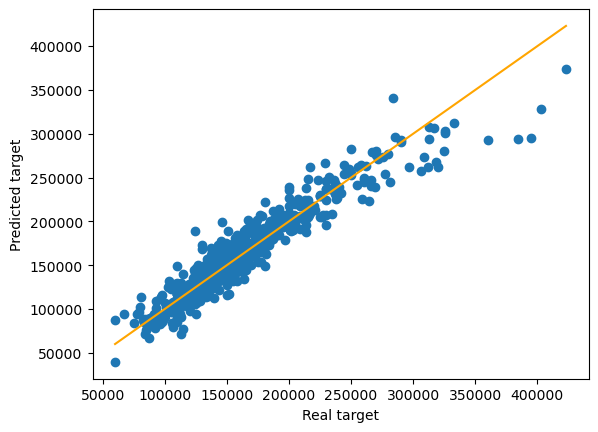

In [20]:
# real vs predicted
real_vs_pred(lr, X_train, y_train)

### K Splits


In [31]:
lr = Pipeline([
    ('feat', PriceByAreaBinTransformer()),
    ('scale', RobustScaler()),
    ('lr', LinearRegression(n_jobs=-1))
])
val_scores = []
k_vals = list(range(0, 50, 2))[1:]

for k in k_vals:
    if k % 10 == 0:
        print("K:", k)
    tmp_kfold = KFold(k, shuffle=True, random_state=42)
    lr_cv = cross_validate(lr, X_train, y_train, cv=tmp_kfold, scoring=scoring, return_train_score=True, n_jobs=-1)
    val_scores.append(lr_cv['test_MAE'].mean().round(1))

K: 10
K: 20
K: 30
K: 40


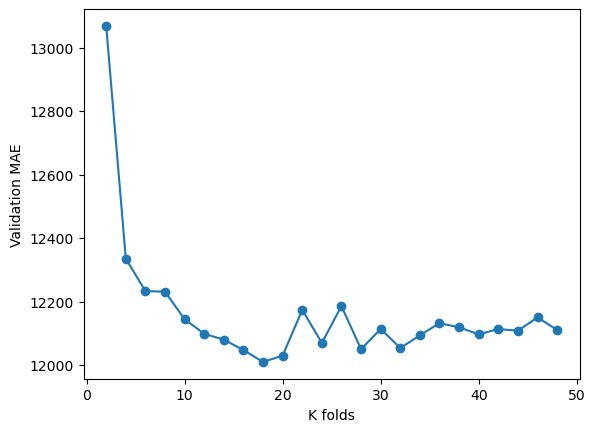

In [33]:
plt.plot(k_vals, val_scores, marker='o')
plt.xlabel('K folds')
plt.ylabel('Validation MAE')
plt.show()

## kNN

### Check `n_neighbors` curves

In [34]:
nneighbors = range(1, 51)

scores = {
    'train_maes': [],
    'val_maes': [],
}

for n in nneighbors:
    knn = Pipeline([
        ('feat', PriceByAreaBinTransformer()),
        ('scale', RobustScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=n, n_jobs=-1))
    ])

    knn_cv = cross_validate(knn, X_train, y_train, cv=main_kfold,
                            scoring=scoring, return_train_score=True, n_jobs=-1)
    scores['train_maes'].append(knn_cv['train_MAE'].mean().round(1))
    scores['val_maes'].append(knn_cv['test_MAE'].mean().round(1))

best_idx = np.argmin(scores['val_maes'])
print('Best Validation MAE:')
print('Train MAE:', scores['train_maes'][best_idx])
print('Validation MAE:', scores['val_maes'][best_idx])
print('N neighbors:', nneighbors[best_idx])

Best Validation MAE:
Train MAE: 12290.1
Validation MAE: 15263.6
N neighbors: 5


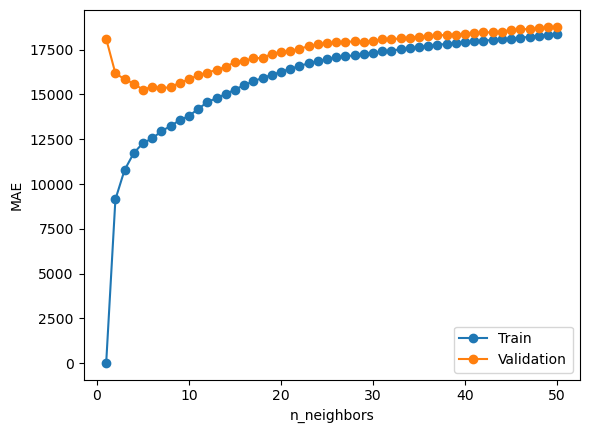

In [35]:
plt.plot(nneighbors, scores[f'train_maes'], label='Train', marker='o')
plt.plot(nneighbors, scores[f'val_maes'], label='Validation', marker='o')

plt.xlabel('n_neighbors')
plt.ylabel('MAE')
plt.legend()
plt.show()

### No data scaling

In [36]:
knn_no_pipe = KNeighborsRegressor(n_neighbors=8, n_jobs=-1)
knn_no_pipe_cv = cross_validate(knn_no_pipe, X_train, y_train, cv=main_kfold,
                                scoring=scoring, return_train_score=True, n_jobs=-1)
print_reg_scores(knn_no_pipe_cv)

Train MAE: 17162.1
Validation MAE: 19852.4

Train MedAE: 12397.2
Validation MedAE: 13964.5


### Noisy Features

In [37]:
# Create noisy DF with 100 random features

rand_df = pd.DataFrame(
    np.random.random(size=(X_train.shape[0], 100)),
    columns=[f'rand_{i}' for i in range(100)])
rand_df.index = X_train.index  # align indices before concatenating
X_train_noise = pd.concat([X_train, rand_df], axis=1)
X_train_noise

,MSZoning,LotArea,Street,LandSlope,HouseStyle,YearBuilt,YearRemodAdd,TotalBsmtSF,CentralAir,Electrical,...,rand_90,rand_91,rand_92,rand_93,rand_94,rand_95,rand_96,rand_97,rand_98,rand_99
360,3.0,7015,1.0,0.0,1.0,1950.0,1950,709,1.0,3.0,...,0.571173,0.045969,0.332711,0.568808,0.119836,0.179292,0.006701,0.619767,0.453272,0.794412
264,3.0,11645,1.0,0.0,5.0,2005.0,2005,1734,1.0,3.0,...,0.519877,0.675302,0.919044,0.502323,0.627562,0.011550,0.658670,0.434178,0.991978,0.283706
440,3.0,6762,1.0,0.0,5.0,2006.0,2006,1187,1.0,3.0,...,0.306279,0.966061,0.391279,0.501036,0.985677,0.107985,0.569985,0.112325,0.662916,0.035534
328,1.0,7200,1.0,0.0,1.0,1938.0,1995,803,1.0,3.0,...,0.707709,0.284635,0.410188,0.469160,0.096003,0.518789,0.319971,0.771658,0.524186,0.152098
486,3.0,11235,1.0,0.0,5.0,1963.0,1979,1051,1.0,3.0,...,0.022376,0.722656,0.593445,0.517993,0.624188,0.016183,0.171587,0.546815,0.810651,0.741295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1.0,12150,1.0,0.0,1.0,1954.0,1954,1050,0.0,1.0,...,0.064158,0.744148,0.268530,0.919954,0.274795,0.288502,0.244818,0.846577,0.004639,0.111707
106,1.0,4500,1.0,0.0,5.0,1999.0,1999,1224,1.0,3.0,...,0.688976,0.527574,0.696317,0.969173,0.083575,0.811114,0.707600,0.018523,0.816713,0.716391
270,3.0,10634,1.0,0.0,5.0,1953.0,1953,608,1.0,3.0,...,0.384378,0.089406,0.793583,0.330913,0.335022,0.513763,0.967031,0.967982,0.641585,0.955220
435,1.0,8520,1.0,0.0,5.0,1928.0,2003,624,1.0,3.0,...,0.715901,0.014762,0.029088,0.715107,0.789170,0.742653,0.785681,0.767413,0.814495,0.570537


In [38]:
noisy_val_mae = []
noisy_fts = range(0, 101, 10)

for i in noisy_fts:
    knn_noise = Pipeline([
        ('scale', RobustScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=5, n_jobs=-1))
    ])
    # Take only first i noisy features
    limit = X_train.shape[1] + i + 1
    knn_noise_cv = cross_validate(knn_noise, X_train_noise.iloc[:, :limit], y_train, cv=main_kfold,
                                scoring=scoring, return_train_score=True, n_jobs=-1)
    # Store validation MAE
    noisy_val_mae.append(knn_noise_cv['test_MAE'].mean().round(1))

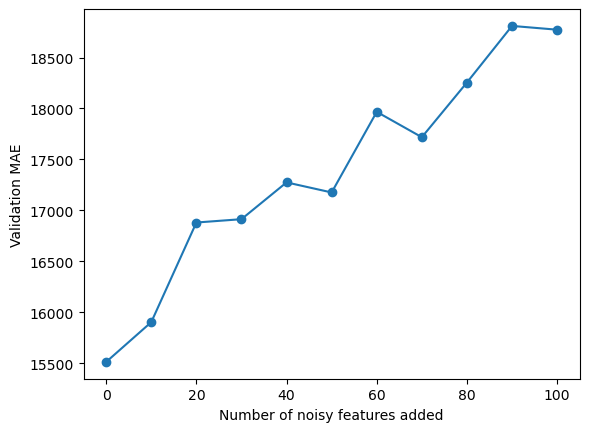

In [39]:
plt.plot(noisy_fts, noisy_val_mae, marker='o')
plt.xlabel('Number of noisy features added')
plt.ylabel('Validation MAE')
plt.show()

### Heatmap

In [40]:
nneighbors = range(1, 21)
ps = range(1, 6)
scores = {
    'train_maes': [],
    'val_maes': []
}

for n in nneighbors:
    t = time.time()
    for p_ in ps:
        knn_pipe = Pipeline([
            ('scale', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=n, p=p_, weights='distance', n_jobs=-1))
        ])

        knn_cv = cross_validate(knn_pipe, X_train, y_train, cv=main_kfold,
                                scoring=scoring, return_train_score=True, n_jobs=-1)
        scores['train_maes'].append(knn_cv['train_MAE'].mean().round(1))
        scores['val_maes'].append(knn_cv['test_MAE'].mean().round(1))
    print(n, round(time.time() - t, 1))

1 1.0
2 1.1
3 1.0
4 1.0
5 1.0
6 1.0
7 1.1
8 0.9
9 0.9
10 1.0
11 0.9
12 1.0
13 0.9
14 0.9
15 1.1
16 1.1
17 0.9
18 1.0
19 1.1
20 1.0


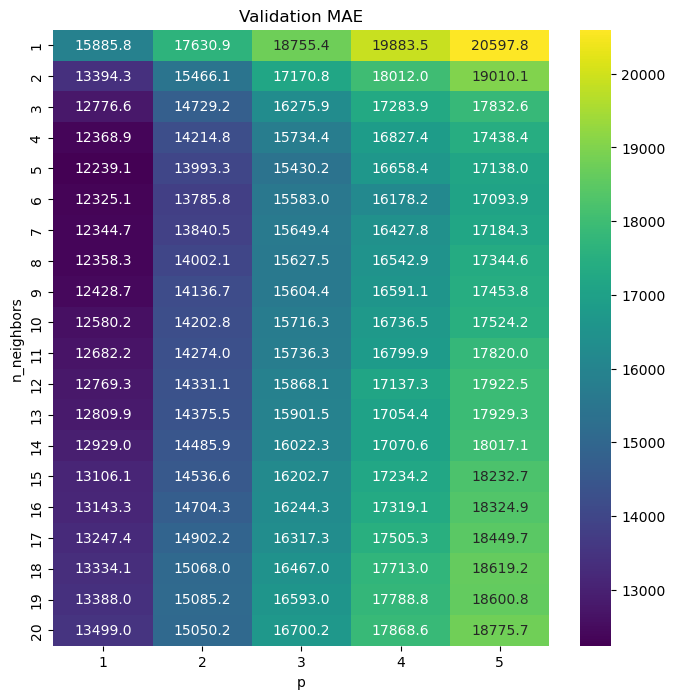

In [41]:
perf_matrix = np.array(scores['val_maes']).reshape(len(nneighbors), len(ps))
knn_perf = pd.DataFrame(perf_matrix, index=nneighbors, columns=ps)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(knn_perf, annot=True, fmt='.1f', cmap='viridis', ax=ax)
plt.xlabel('p')
plt.ylabel('n_neighbors')
plt.title('Validation MAE')
plt.show()

### Hyperparameter tunning

In [43]:
knn = Pipeline([
    ('scaler', None),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])

params = [{
    'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'knn__n_neighbors': np.arange(1, 30),
    'knn__p': np.arange(1, 10),
    'knn__weights': ['uniform', 'distance']
}]

knn_rs = RandomizedSearchCV(knn,
                            n_iter=30,
                            param_distributions=params,
                            scoring=scoring,
                            cv=main_kfold,
                            refit=lambda x: x["mean_test_MAE"].argmin(),
                            return_train_score=True,
                            n_jobs=-1)

knn_rs.fit(X_train, y_train)

print_rs_reg_scores(knn_rs, knn_rs.best_index_)

{'scaler': RobustScaler(), 'knn__weights': 'distance', 'knn__p': np.int64(2), 'knn__n_neighbors': np.int64(2)}

Train MAE: 29.1
Validation MAE: 16153.9

Train MedAE: 0.0
Validation MedAE: 10764.4


In [45]:
# Display best 3 hyperparams
sorted(zip(range(30), knn_rs.cv_results_['params'], knn_rs.cv_results_['mean_train_MAE'], knn_rs.cv_results_['mean_test_MAE']), key=lambda x: x[3])[:3]

[(23,
  {'scaler': RobustScaler(),
   'knn__weights': 'distance',
   'knn__p': np.int64(2),
   'knn__n_neighbors': np.int64(2)},
  np.float64(29.11902964045587),
  np.float64(16153.863384823391)),
 (18,
  {'scaler': StandardScaler(),
   'knn__weights': 'distance',
   'knn__p': np.int64(3),
   'knn__n_neighbors': np.int64(16)},
  np.float64(29.117913610032694),
  np.float64(16244.339923666103)),
 (22,
  {'scaler': RobustScaler(),
   'knn__weights': 'uniform',
   'knn__p': np.int64(2),
   'knn__n_neighbors': np.int64(11)},
  np.float64(14441.431513010155),
  np.float64(16265.63823728355))]

## DT decision tree

In [46]:
max_depth = range(1, 51)

scores = {
    'train_maes': [],
    'val_maes': [],
}

for n in max_depth:
    dt = DecisionTreeRegressor(max_depth=n)

    dt_cv = cross_validate(dt, X_train, y_train, cv=main_kfold,
                           scoring=scoring, return_train_score=True, n_jobs=-1)
    scores['train_maes'].append(dt_cv['train_MAE'].mean().round(1))
    scores['val_maes'].append(dt_cv['test_MAE'].mean().round(1))

best_idx = np.argmin(scores['val_maes'])
print('Best Validation MAE:')
print('Train MAE:', scores['train_maes'][best_idx])
print('Validation MAE:', scores['val_maes'][best_idx])
print('Max depth:', nneighbors[best_idx])

Best Validation MAE:
Train MAE: 5760.2
Validation MAE: 13995.6
Max depth: 7


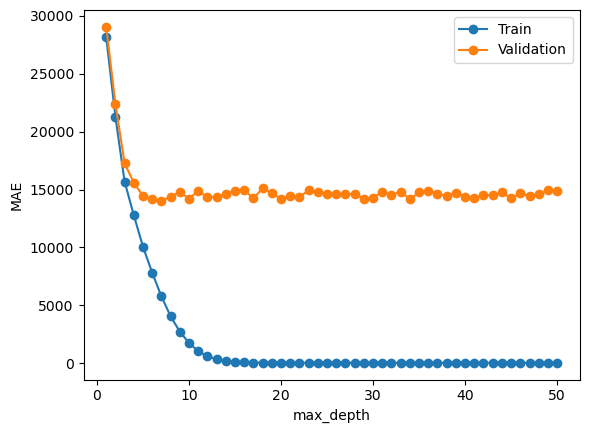

In [47]:
plt.plot(max_depth, scores[f'train_maes'], label='Train', marker='o')
plt.plot(max_depth, scores[f'val_maes'], label='Validation', marker='o')

plt.xlabel('max_depth')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Hyperparameter tunning

In [48]:
dt = Pipeline([
    ('feat', PriceByAreaBinTransformer()),
    ('dt', DecisionTreeRegressor()),
])

params = {
    'dt__max_depth': list(range(1, 30)) + [None],
    'dt__min_samples_split': range(2, 100),
    'dt__min_samples_leaf': range(1, 100),
    'dt__max_leaf_nodes': range(2, 50),
    'dt__criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
}

dt_rs = RandomizedSearchCV(dt,
                           param_distributions=params,
                           n_iter=100,
                           scoring=scoring,
                           cv=main_kfold,
                           return_train_score=True,
                           refit=lambda x: x["mean_test_MAE"].argmin(),
                           n_jobs=-1)

dt_rs.fit(X_train, y_train)

print_rs_reg_scores(dt_rs, dt_rs.best_index_)

{'dt__min_samples_split': 28, 'dt__min_samples_leaf': 3, 'dt__max_leaf_nodes': 24, 'dt__max_depth': 22, 'dt__criterion': 'squared_error'}

Train MAE: 11273.0
Validation MAE: 14574.5

Train MedAE: 8607.2
Validation MedAE: 11450.9


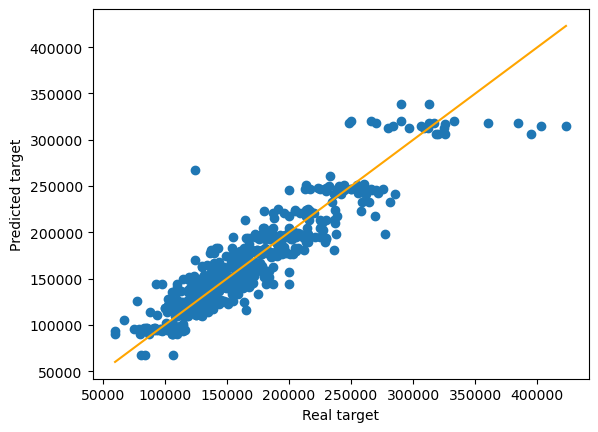

In [49]:
# real vs predicted
real_vs_pred(dt_rs.best_estimator_, X_train, y_train)

In [58]:
dt['dt']

DecisionTreeRegressor(max_depth=3, max_leaf_nodes=24, min_samples_leaf=3,
                      min_samples_split=28)

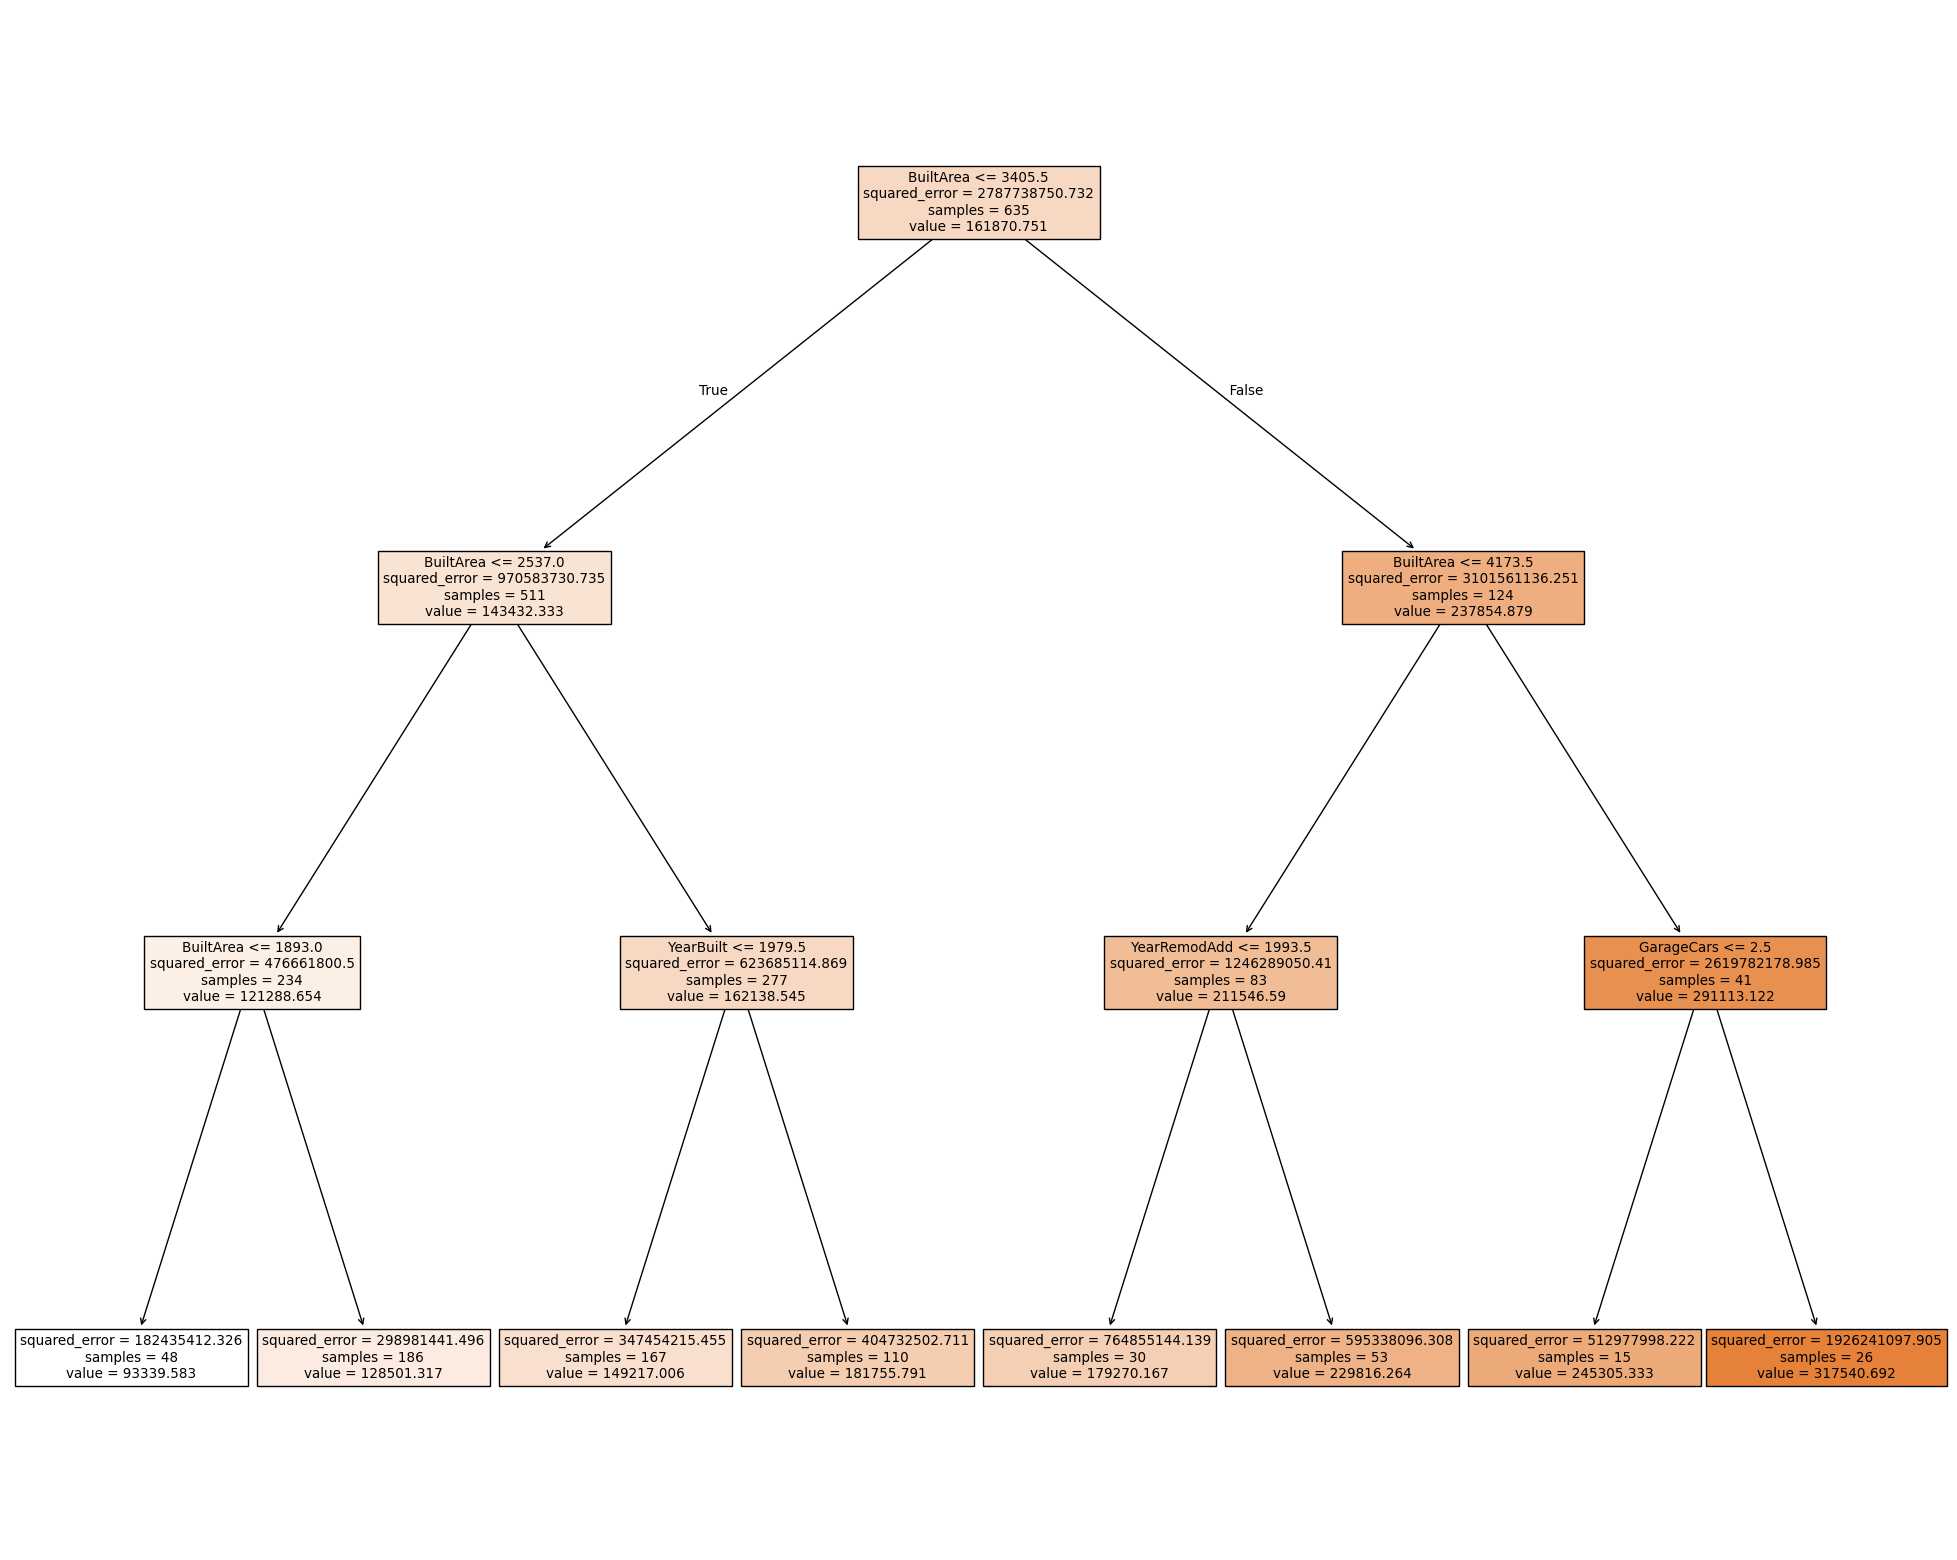

In [59]:
# Use best parameters with max_depth 3
best_params = {k.replace('dt__', ''): v for k, v in dt_rs.best_params_.items()}
best_params['max_depth'] = 3

dt = Pipeline([
    ('feat', PriceByAreaBinTransformer()),
    ('dt', DecisionTreeRegressor(**best_params)),
])
dt.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt['dt'],
                   feature_names=X_train.columns,  
                   class_names=y_train,
                   filled=True)

## RF

In [61]:
rf = Pipeline([
    ('feat', PriceByAreaBinTransformer()),
    ('rf', RandomForestRegressor(n_jobs=-1, random_state=42)),
])

params = [{
    'rf__n_estimators': [100, 200, 300],
    'rf__criterion': ['friedman_mse', 'squared_error', 'absolute_error'],
    'rf__min_samples_split': [2, 5, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4, 6],
    'rf__max_depth': [3, 4, 5, 6, 8, 10, 20, 50],
    'rf__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9],
    'rf__max_samples': [None, 0.5, 0.7, 0.9],
    'rf__max_leaf_nodes': [None, 5, 10, 20],
    'rf__min_weight_fraction_leaf': np.arange(0, 0.51, 0.1),
}]

rf_rs = RandomizedSearchCV(rf,
                           n_iter=200,
                           param_distributions=params,
                           scoring=scoring,
                           cv=main_kfold,
                           refit=lambda x: x["mean_test_MAE"].argmin(),
                           return_train_score=True,
                           n_jobs=-1)

rf_rs.fit(X_train, y_train)

print_rs_reg_scores(rf_rs, rf_rs.best_index_)

{'rf__n_estimators': 200, 'rf__min_weight_fraction_leaf': np.float64(0.0), 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_samples': 0.9, 'rf__max_leaf_nodes': None, 'rf__max_features': None, 'rf__max_depth': 20, 'rf__criterion': 'absolute_error'}

Train MAE: 4463.1
Validation MAE: 10925.9

Train MedAE: 3387.3
Validation MedAE: 8180.6


In [62]:
# Display best 3 hyperparams
sorted(zip(range(200), rf_rs.cv_results_['params'], rf_rs.cv_results_['mean_train_MAE'], rf_rs.cv_results_['mean_test_MAE']), key=lambda x: x[3])[:3]

[(8,
  {'rf__n_estimators': 200,
   'rf__min_weight_fraction_leaf': np.float64(0.0),
   'rf__min_samples_split': 2,
   'rf__min_samples_leaf': 1,
   'rf__max_samples': 0.9,
   'rf__max_leaf_nodes': None,
   'rf__max_features': None,
   'rf__max_depth': 20,
   'rf__criterion': 'absolute_error'},
  np.float64(4463.148710051988),
  np.float64(10925.938845548115)),
 (132,
  {'rf__n_estimators': 300,
   'rf__min_weight_fraction_leaf': np.float64(0.0),
   'rf__min_samples_split': 2,
   'rf__min_samples_leaf': 1,
   'rf__max_samples': 0.7,
   'rf__max_leaf_nodes': None,
   'rf__max_features': 0.5,
   'rf__max_depth': 6,
   'rf__criterion': 'squared_error'},
  np.float64(7780.2686933400455),
  np.float64(11119.687013085504)),
 (70,
  {'rf__n_estimators': 200,
   'rf__min_weight_fraction_leaf': np.float64(0.0),
   'rf__min_samples_split': 10,
   'rf__min_samples_leaf': 4,
   'rf__max_samples': 0.7,
   'rf__max_leaf_nodes': None,
   'rf__max_features': 'log2',
   'rf__max_depth': 6,
   'rf__crit

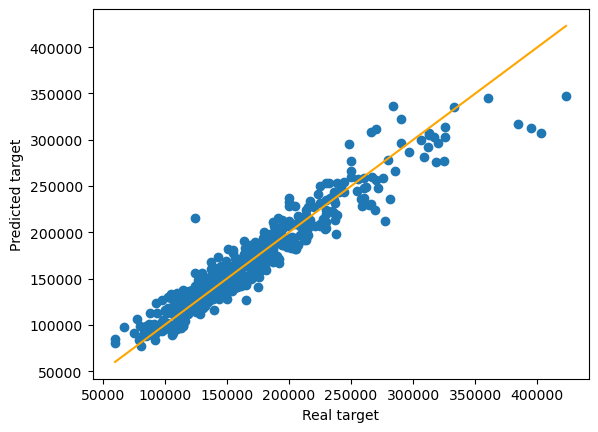

In [63]:
# real vs predicted
real_vs_pred(rf_rs.best_estimator_, X_train, y_train)

In [67]:
len(rf_rs.best_estimator_['rf'].feature_importances_)

48

In [66]:
rf_rs.best_estimator_.fit(X_train, y_train)

rf_ft_imps = pd.DataFrame({
    'feature': list(X_train.columns) + ['SalePrice_by_AreaBin'],
    'importance': rf_rs.best_estimator_['rf'].feature_importances_
}).sort_values('importance', ascending=False).round(3)

rf_ft_imps.head(20)

,feature,importance
28,BuiltArea,0.518
5,YearBuilt,0.117
12,GrLivArea,0.041
6,YearRemodAdd,0.030
22,GarageArea,0.026
1,LotArea,0.022
21,GarageCars,0.020
10,1stFlrSF,0.017
7,TotalBsmtSF,0.017
29,BuiltAreaPerc,0.017


## GBDT

In [68]:
gb = GradientBoostingRegressor()

params = {
    'loss': ['quantile', 'squared_error', 'absolute_error', 'huber'],
    'learning_rate': np.logspace(-3, 0, 10),
    'n_estimators': [20, 50, 100, 200, 300, 500, 1000],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 8, 10, 20],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'max_leaf_nodes': [None, 5, 10, 20],
    'validation_fraction': [0.1, 0.2],
}

gb_rs = RandomizedSearchCV(gb,
                           n_iter=50,
                           param_distributions=params,
                           scoring=scoring,
                           cv=main_kfold,
                           refit=lambda x: x["mean_test_MAE"].argmin(),
                           return_train_score=True,
                           n_jobs=-1)

gb_rs.fit(X_train, y_train)

print_rs_reg_scores(gb_rs, gb_rs.best_index_)

{'validation_fraction': 0.2, 'subsample': 0.9, 'n_estimators': 1000, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': 20, 'max_features': 0.5, 'max_depth': 10, 'loss': 'squared_error', 'learning_rate': np.float64(0.004641588833612777), 'criterion': 'friedman_mse'}

Train MAE: 4256.2
Validation MAE: 9280.5

Train MedAE: 3549.8
Validation MedAE: 6963.4


In [69]:
gb_rs.cv_results_['mean_test_MAE']

array([14917.04334539, 40476.1821293 , 15561.66933384, 29445.86328352,
       17215.3927461 , 30994.99343904, 66925.49094137, 13738.59382127,
       25957.43741331, 11801.13093196,  9681.29747128, 22457.85774927,
       15631.2827742 , 21330.99727183, 14816.00094784, 14060.33562137,
       16632.8623206 , 76956.16118312, 55681.30612537, 16431.97805073,
       20736.08757716, 38470.43244737, 25779.92385061, 21377.61261713,
       13675.63693696, 32397.48852322, 19136.60509854,  9466.75516692,
       30932.47927162, 11710.33012603, 20637.01408734, 10844.67396014,
       21852.4485917 , 13463.98986298, 12065.52035312, 18177.54268312,
       10360.5589499 , 34180.35735884, 19512.94479913, 18807.10870536,
        9965.33895662, 22775.49371094, 19483.78966454, 10816.99571302,
       73411.84063211, 36797.93828006, 33187.51454908, 33039.348065  ,
       52995.40766738,  9280.50041215])

In [70]:
# Get the indices of the smallest MAE values
best_indices = np.argsort(gb_rs.cv_results_['mean_test_MAE'])[:5]

# Show best MAEs and their corresponding hyperparams.
for i in best_indices:
    print('MAE:', gb_rs.cv_results_['mean_test_MAE'][i].round(2))
    print('Hyperparams:', gb_rs.cv_results_['params'][i])
    print()

MAE: 9280.5
Hyperparams: {'validation_fraction': 0.2, 'subsample': 0.9, 'n_estimators': 1000, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': 20, 'max_features': 0.5, 'max_depth': 10, 'loss': 'squared_error', 'learning_rate': np.float64(0.004641588833612777), 'criterion': 'friedman_mse'}

MAE: 9466.76
Hyperparams: {'validation_fraction': 0.2, 'subsample': 1.0, 'n_estimators': 300, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 20, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 10, 'max_features': None, 'max_depth': 4, 'loss': 'huber', 'learning_rate': np.float64(0.046415888336127774), 'criterion': 'friedman_mse'}

MAE: 9681.3
Hyperparams: {'validation_fraction': 0.2, 'subsample': 0.5, 'n_estimators': 500, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.1, 'max_leaf_nodes': 10, 'max_features': 0.5, 'max_depth': 4, 'lo

### Round 2

In [ ]:
gb = GradientBoostingRegressor(
    validation_fraction=0.2,
    min_weight_fraction_leaf=0,
    criterion='friedman_mse',
)

params = {
    'loss': ['absolute_error', 'huber'],
    'learning_rate': np.logspace(-2, 0, 10),
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'n_estimators': [300, 1000, 1500, 2000],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [3, 5, 10, 20, 30],
    'min_impurity_decrease': [0, 0.01, 0.1],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [5, 10, 20, 25],
}

gb_rs = RandomizedSearchCV(gb,
                           n_iter=50,
                           param_distributions=params,
                           scoring=scoring,
                           cv=main_kfold,
                           refit=lambda x: x["mean_test_MAE"].argmin(),
                           return_train_score=True,
                           n_jobs=-1)

gb_rs.fit(X_train, y_train)

print_rs_reg_scores(gb_rs, gb_rs.best_index_)

{'subsample': 0.9, 'n_estimators': 1500, 'min_samples_split': 3, 'min_samples_leaf': 2, 'min_impurity_decrease': 0, 'max_leaf_nodes': 5, 'max_features': 'sqrt', 'max_depth': 8, 'loss': 'huber', 'learning_rate': np.float64(0.046415888336127774)}

Train MAE: 2323.5
Validation MAE: 8882.1

Train MedAE: 1663.8
Validation MedAE: 7127.3


In [81]:
y_pred = cross_val_predict(gb_rs.best_estimator_, X_train, y_train, cv=main_kfold, n_jobs=-1)
errs = abs(y_train - y_pred)

print('MAE:', mean_absolute_error(y_train, y_pred))
print('Q1 err:', np.percentile(errs, 25))
print('Q2 err:', np.percentile(errs, 50))
print('Q3 err:', np.percentile(errs, 75))

MAE: 9280.820375953766
Q1 err: 3404.861812830706
Q2 err: 6894.74510252825
Q3 err: 12971.426654243158


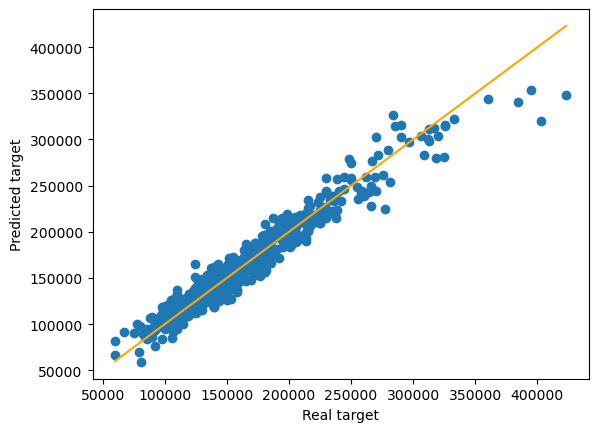

In [82]:
# real vs predicted
real_vs_pred(gb_rs.best_estimator_, X_train, y_train)

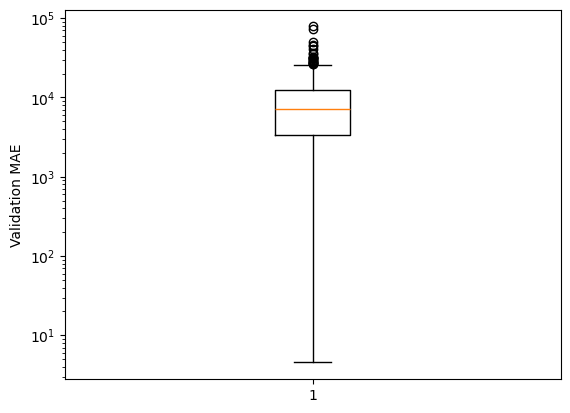

In [83]:
y_val_pred = cross_val_predict(gb_rs.best_estimator_, X_train, y_train, cv=main_kfold, n_jobs=-1)

plt.boxplot(abs(y_train - y_val_pred))
plt.ylabel('Validation MAE')
plt.yscale('log')
plt.show()

In [84]:
gbdt = GradientBoostingRegressor(**{'n_estimators': 1000, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 6, 'min_impurity_decrease': 0,
                                    'max_leaf_nodes': 5, 'max_features': 'log2', 'max_depth': 8, 'loss': 'absolute_error', 'learning_rate': np.float64(0.046415888336127774)})

create_submission(gbdt, leaderboard_df, fts2drop)

## Summary

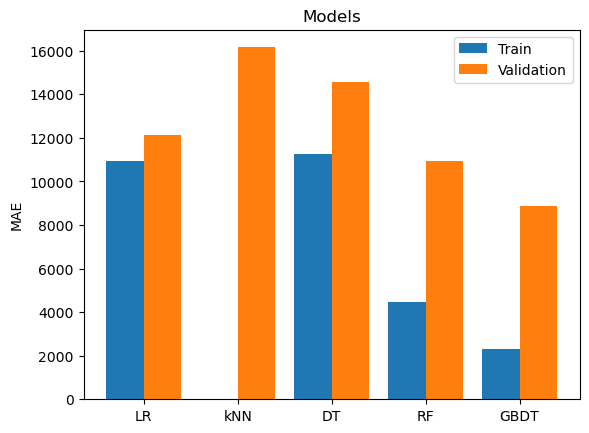

In [85]:
models = [
    ('LR', lr_cv),
    ('kNN', knn_rs),
    ('DT', dt_rs),
    ('RF', rf_rs),
    ('GBDT', gb_rs),
]

y_train_axis = []
y_valid_axis = []

for name, model in models:
    if name == 'LR':
        y_train_axis.append(model['train_MAE'].mean())
        y_valid_axis.append(model['test_MAE'].mean())
    else:
        y_train_axis.append(model.cv_results_['mean_train_MAE'][model.best_index_])
        y_valid_axis.append(model.cv_results_['mean_test_MAE'][model.best_index_])

x_axis = np.arange(len(models))
plt.bar(x_axis - 0.2, y_train_axis, 0.4, label = 'Train')
plt.bar(x_axis + 0.2, y_valid_axis, 0.4, label = 'Validation')

plt.xticks(x_axis, [name for name, _ in models])
plt.ylabel('MAE')
plt.title('Models')
plt.legend()
plt.show()

# Test

Choose the most promising models and test them.

kNN
Train MAE: 32.75664813826348
Test MAE: 16493.69854989336
Test MedAE: 10550.9180243788

RF
Train MAE: 4402.717755905513
Test MAE: 12144.02863207547
Test MedAE: 8144.549999999988

GBDT
Train MAE: 2574.888658722063
Test MAE: 10283.056963460907
Test MedAE: 7720.59566863162



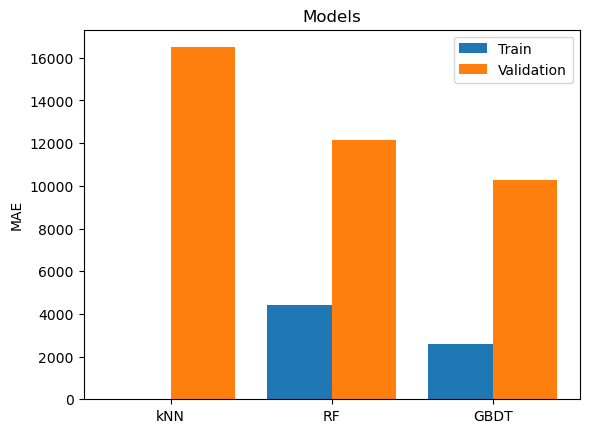

In [86]:
models = [
    ('kNN', knn_rs),
    ('RF', rf_rs),
    ('GBDT', gb_rs),
]

y_train_axis = []
y_valid_axis = []

for name, model in models:
    model.best_estimator_.fit(X_train, y_train)
    y_train_pred = model.best_estimator_.predict(X_train)
    y_test_pred = model.best_estimator_.predict(X_test)
    y_train_axis.append(mean_absolute_error(y_train, y_train_pred))
    y_valid_axis.append(mean_absolute_error(y_test, y_test_pred))
    print(name)
    print('Train MAE:', mean_absolute_error(y_train, y_train_pred))
    print('Test MAE:', mean_absolute_error(y_test, y_test_pred))
    print('Test MedAE:', median_absolute_error(y_test, y_test_pred))
    print()

x_axis = np.arange(len(models))
plt.bar(x_axis - 0.2, y_train_axis, 0.4, label = 'Train')
plt.bar(x_axis + 0.2, y_valid_axis, 0.4, label = 'Validation')
  
plt.xticks(x_axis, [name for name, _ in models])
plt.ylabel('MAE')
plt.title('Models')
plt.legend()
plt.show()

# Save Model

Saving the model as a `pickle`, meaning that the Python's object (which is a trained model) is stored as a file in the specified path.

`gb_rs` is an object of `RandomizedSearchCV` type. Out of all the hyperparameters it tried, it stored the best model in the `best_estimator_` attribute.

Then, `gb_rs.best_estimator_` is a `GradientBoostingRegressor` object, which is trained with all training data (X_train and y_train), as you can see in the cell above.

If we think our model is robust enough, one good option is to train it with all the available data we have. However, the absence of additional data to test the model introduces the risk of deploying an unvalidated model to production. To mitigate this risk, we can employ thorough cross-validation on the complete dataset. By using a big number of splits, we ensure a more exhaustive assessment of the model's performance. If the model consistently performs well across numerous cross-validation folds, we can be more assured that expanding the entire dataset will not lead to adverse outcomes in a production environment. This approach does not entirely eliminate the risk, but it significantly bolsters our confidence in the model's generalizability.

In [87]:
import pickle

In [88]:
type(gb_rs)

sklearn.model_selection._search.RandomizedSearchCV

In [89]:
type(gb_rs.best_estimator_)

sklearn.ensemble._gb.GradientBoostingRegressor

In [90]:
final_cv = cross_validate(gb_rs.best_estimator_, X, y, cv=200,
                          scoring=scoring, return_train_score=True, n_jobs=-1)
print_reg_scores(final_cv)

Train MAE: 3020.7
Validation MAE: 8967.4

Train MedAE: 2243.3
Validation MedAE: 7820.9


As we get a good average performance in the cross-validation with all the data, we decide to finally train our model with the whole dataset.

In [91]:
gb_rs.best_estimator_.fit(X, y)

GradientBoostingRegressor(learning_rate=np.float64(0.046415888336127774),
                          loss='huber', max_depth=8, max_features='sqrt',
                          max_leaf_nodes=5, min_impurity_decrease=0,
                          min_samples_leaf=2, min_samples_split=3,
                          min_weight_fraction_leaf=0, n_estimators=1500,
                          subsample=0.9, validation_fraction=0.2)

And store it in a file:

In [92]:
with open('model_gbdt.pkl', 'wb') as f:
    pickle.dump(gb_rs.best_estimator_, f)

# Load Model

We can load and use a trained model stored in a `pickle` file.

`gb` is now a `GradientBoostingRegressor` object that is already trained with X_train and y_train, as this is the model that was previously stored.

We can load and use this object for predicting sale prices of any house data we want, as long as the features are the same as the trained model.

In [93]:
with open('model_gbdt.pkl', 'rb') as f:
    gb = pickle.load(f)

In [94]:
type(gb)

sklearn.ensemble._gb.GradientBoostingRegressor

Given any dataset of unknown prices, we can now predict its prices (imagine we don't know `X_tests` prices):

In [95]:
X_unknown = X_test.sample(10)
X_unknown

,MSZoning,LotArea,Street,LandSlope,HouseStyle,YearBuilt,YearRemodAdd,TotalBsmtSF,CentralAir,Electrical,...,RoofStyle_Mansard,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
65,1.0,1974,1.0,0.0,7.0,1973.0,1973,546,1.0,3.0,...,0,1,0,0,0,1,0,0,0,0
405,1.0,2665,1.0,0.0,7.0,1976.0,1976,264,1.0,3.0,...,0,0,1,0,0,0,0,1,0,0
110,3.0,11308,1.0,0.0,7.0,2008.0,2008,1104,1.0,3.0,...,0,0,1,0,0,1,0,0,0,0
462,3.0,7244,1.0,0.0,2.0,1970.0,1970,768,1.0,3.0,...,0,1,0,0,0,0,0,0,0,1
101,3.0,11302,1.0,0.0,5.0,2005.0,2006,1814,1.0,3.0,...,0,0,1,0,0,1,0,0,0,0
66,1.0,1596,1.0,0.0,4.0,1973.0,1973,462,1.0,3.0,...,0,1,0,0,0,0,0,1,0,0
543,4.0,2280,1.0,0.0,7.0,1999.0,1999,744,1.0,3.0,...,0,0,1,0,0,0,0,0,0,1
365,3.0,7851,1.0,0.0,7.0,2002.0,2002,860,1.0,3.0,...,0,0,1,0,0,0,0,1,0,0
589,3.0,11175,1.0,0.0,5.0,2007.0,2007,1316,1.0,3.0,...,0,0,1,0,0,1,0,0,0,0
420,3.0,6858,1.0,0.0,7.0,1915.0,1950,806,0.0,1.0,...,0,0,1,0,0,0,0,0,0,1


In [96]:
# Predicted prices
gb.predict(X_unknown)

array([ 85120.27370981, 115333.61612226, 335826.7727121 , 130019.05215189,
       318343.90070113,  90552.74228882, 174780.54590927, 217405.17547559,
       193723.92806803, 130241.6016573 ])

We can predict as many instances as we want. For example, a single instance:

In [97]:
# Single series element
x_single = X_test.sample(1)
x_single

,MSZoning,LotArea,Street,LandSlope,HouseStyle,YearBuilt,YearRemodAdd,TotalBsmtSF,CentralAir,Electrical,...,RoofStyle_Mansard,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
209,3.0,8499,1.0,0.0,7.0,2006.0,2007,616,1.0,3.0,...,0,0,1,0,0,0,0,1,0,0


In [98]:
# Predicted price
gb.predict(x_single)

array([160421.68605337])